# PROYECTO 4 - MACHINE LEARNING

## Integrantes:
1. Marcelo
2. Alvaro
3. Adrian
4. 

---

# 1. Preparación y analisis de datos

In [1]:
# %pip install numpy
# %pip install matplotlib
# %pip install scipy
# %pip install pandas
# %pip install scikit-learn
# %pip install seaborn
# %pip install nltk

In [2]:
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import torch
from torch.utils.data import DataLoader, TensorDataset

from matplotlib import rcParams
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.random.seed(2024)

In [22]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_train.describe()

,message,label
count,25000,25000
unique,24904,2
top,How has this piece of crap stayed on TV this l...,neg
freq,3,12500


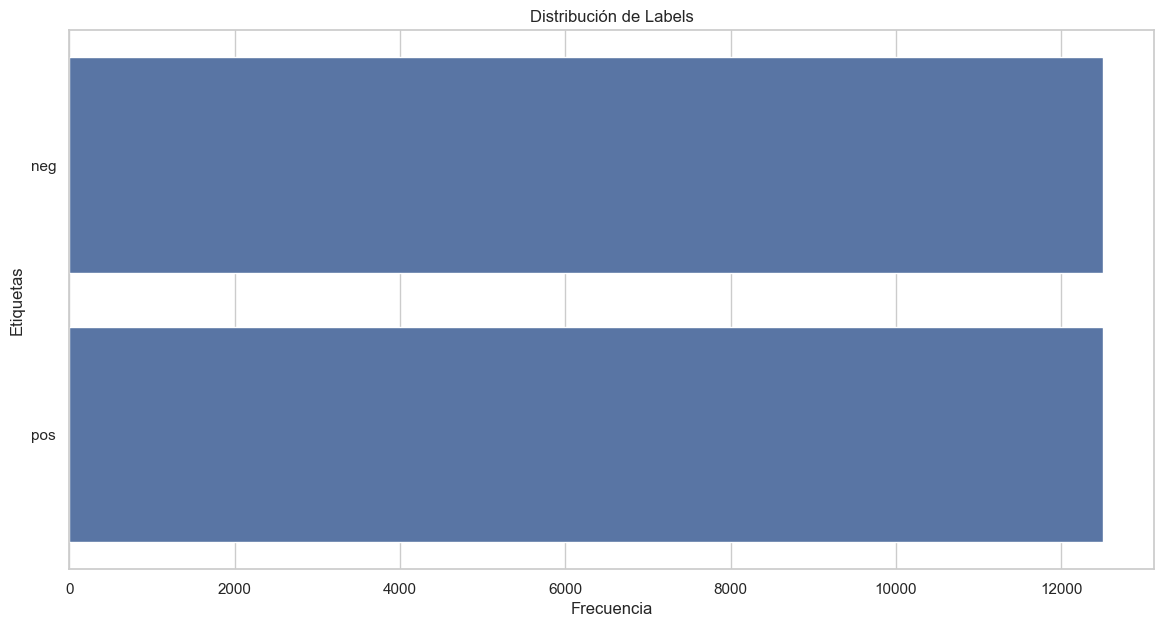

In [23]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.countplot(df_train.iloc[:, 1], order=df_train.iloc[:, 1].value_counts().index)

# Configurar los títulos y etiquetas
plt.title('Distribución de Labels')
plt.xlabel('Frecuencia')
plt.ylabel('Etiquetas')

# Mostrar la gráfica
plt.show()

----
# 2. Prepocesamiento

## TF-IDF

### Tokenizar, eliminar stopwords y Part-Of-Speech tag

In [178]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Lista de palabras de negación sintáctica
syntactic_negations = set(["no", "not", "none", "never", "neither", "nor", "cannot", "can't"])

# Lista de prefijos de negación morfológica
morphological_prefixes = ["un", "in", "dis", "im", "ir", "non", "anti"]

def tokenize(text):
    # return [word for word in word_tokenize(text.lower()) if word.isalpha() and word not in stop_words]
    return [word for word in word_tokenize(text.lower()) if word.isalpha()]

def pos_tagging(tokens):
    return pos_tag(tokens)

# Función para convertir etiquetas de POS de NLTK a etiquetas de WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def mark_negations(tokens):
    # Marca las palabras y frases con negaciones.
    negated_tokens = []
    negation = False
    for token in tokens:
        if token in syntactic_negations:
            negation = True
            negated_tokens.append(token)
        elif negation:
            if token in stop_words:
                negated_tokens.append(token)
            else:
                negated_tokens.append(token + "_NEG")
                negation = False
        else:
            negated_tokens.append(token)
    
    return negated_tokens

# def mark_negations(tokens):
#     negated_tokens = []
#     negation = False
#     for i, token in enumerate(tokens):
#         if token in syntactic_negations:
#             negation = True
#             negated_tokens.append(token)
#         elif negation:
#             if token in stop_words:
#                 negated_tokens.append(token)
#             else:
#                 negated_tokens.append(token + "_NEG")
#                 # Detectar doble negación
#                 if i > 0 and tokens[i - 1] == "not":
#                     negated_tokens[i] = tokens[i]
#                 negation = False
#         else:
#             negated_tokens.append(token)
    
#     return negated_tokens


def handle_morphological_negations(tokens):
    # Marca las palabras con prefijos de negación morfológica.
    negated_tokens = []
    for token in tokens:
        for prefix in morphological_prefixes:
            if token.startswith(prefix):
                root = token[len(prefix):]
                negated_tokens.append(root + "_NEG")
                break
        else:
            negated_tokens.append(token)
    
    return negated_tokens

def handle_double_negations(tokens):
    negated_tokens = []
    for i, token in enumerate(tokens):
        if token.endswith("_NEG_NEG"):
            negated_tokens.append(token[:-8])
        else:
            negated_tokens.append(token)
    
    return negated_tokens

def lemmatize(pos_tags):
    return [lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos) or wordnet.NOUN) for word, pos in pos_tags]

def preprocess(df):
    df['tokens'] = df['message'].apply(tokenize)
    df['tokens'] = df['tokens'].apply(mark_negations)
    df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
    df['tokens'] = df['tokens'].apply(handle_morphological_negations)
    df['tokens'] = df['tokens'].apply(handle_double_negations)
    df['pos_tags'] = df['tokens'].apply(pos_tagging)
    df['lemmas'] = df['pos_tags'].apply(lemmatize)
    return df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [58]:
# Ejemplo de uso
import pandas as pd

data = {'message': ["The audience disliked the actor leading the play.", 
                    "He was not supposed to come.", 
                    "The price of the car is not insignificant."]}

df = pd.DataFrame(data)
processed_df = preprocess(df)

processed_df[['message', 'tokens', 'lemmas']]

,message,tokens,lemmas
0,The audience disliked the actor leading the play.,"[audience, liked_NEG, actor, leading, play]","[audience, liked_NEG, actor, lead, play]"
1,He was not supposed to come.,"[supposed_NEG, come]","[supposed_NEG, come]"
2,The price of the car is not insignificant.,"[price, car, significant]","[price, car, significant]"


In [ ]:
df_train = preprocess(df_train)
df_test = preprocess(df_test)
df_train.to_pickle('df_train_processed.pkl')
df_test.to_pickle('df_test_processed.pkl')

### Cargar data una vez preprocesada

In [6]:
df_train = pd.read_pickle('df_train_processed.pkl')
df_submit = pd.read_pickle('df_test_processed.pkl')

In [7]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=2024)

In [8]:
# use tf-idf to vectorize the text
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(max_features=1000)
tfidf = TfidfVectorizer()

x_train = tfidf.fit_transform(df_train['lemmas'].apply(' '.join))
x_test = tfidf.transform(df_test['lemmas'].apply(' '.join))
x_submit = tfidf.transform(df_submit['lemmas'].apply(' '.join))

In [9]:
#enconde de y a valores numericos
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['label'])
y_test = label_encoder.transform(df_test['label'])


#verificar que significa cada valor numerico
label_encoder.classes_

array(['neg', 'pos'], dtype=object)

In [10]:
from sklearn.feature_selection import SelectKBest, chi2

k = 5000  # Número de características a seleccionar, ajusta este valor según sea necesario
chi2_selector = SelectKBest(chi2, k=k)
x_train_chi2 = chi2_selector.fit_transform(x_train, y_train)
x_test_chi2 = chi2_selector.transform(x_test)
x_submit_chi2 = chi2_selector.transform(x_submit)

In [11]:
n_features = x_train_chi2.shape[1]
print(f'Number of features: {n_features}')

Number of features: 5000


## Character quantization

In [24]:
import pandas as pd
#Funciones auxiliares
def build_char_mat(quote,MAX_LEN,CHAR_DICT):
    char_mat = np.zeros((MAX_LEN, len(CHAR_DICT)), dtype=np.bool_)
    for i, char in enumerate(quote.lower()):
        if i >= MAX_LEN:
            break
        if char in CHAR_DICT:
            char_mat[i,CHAR_DICT[char]] = 1
    return char_mat

def generate_char_dict(string):
    char_dict = {}
    for char in string:
        if char not in char_dict:
            char_dict[char] = len(char_dict)
    return char_dict

def executeCQ(df, alfabet, MAX_LEN):
    df_result = pd.DataFrame(columns=['char_mat', 'label'])
    CHAR_DICT = generate_char_dict(alfabet)
    for index, row in df.iterrows():
        
        #remove special characters that are not in the alphabet
        msg = ''.join([char for char in row['message'] if char in CHAR_DICT])
        char_mat = build_char_mat(msg, MAX_LEN, CHAR_DICT)
        df_result.loc[index] = [char_mat, row['label']]
    return df_result


In [25]:
from sklearn.model_selection import train_test_split
data_processed = executeCQ(df_train, alfabet='abcdefghijklmnopqrstuvwxyz!¡?¿() ', MAX_LEN=5000)
df_train, df_test = train_test_split(data_processed, test_size=0.15, random_state=2024)

----
# 3. Experimentación

In [58]:
# Prepare Colab to work with CUDA.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [23]:
#funciones de experimentación
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

def matriz_confusion(y_test, y_pred, Tipo):
 matrix = confusion_matrix(y_test, y_pred)
 f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index= label_encoder.classes_  , columns=label_encoder.classes_)
 sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
 plt.title("Confusion Matrix - "  + Tipo ), plt.tight_layout()
 plt.xlabel("Predicted")
 plt.ylabel("Real")
 plt.show()

# Write your code here
def test(model, loader, tipo):
  if tipo == "MLP" or tipo == "CNN":
    model.eval()
    with torch.no_grad():
        for x_test, y_test in loader:
          x_test = x_test.to(device)
          y_test = y_test.to(device)
          y_pred = model(x_test)
    
          y_pred = torch.argmax(y_pred, dim=1).cpu()
          y_test = y_test.cpu()
        torch.cuda.empty_cache()
  else:
    y_pred = model.predict(x_test)
    
  print(classification_report(y_test, y_pred))
  matriz_confusion(y_test, y_pred,tipo)

## SVM TEST

In [13]:
# fast test with training with svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
clf = SVC()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

## Neural Networks TEST

### Funciones auxiliares

In [202]:
def train(model, loss_f, optimizer, epochs, train_loader):
    loss_lista = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            y_pred = model(x_batch)
            loss = loss_f(y_pred, y_batch)
            epoch_loss += loss.item()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_epoch_loss = epoch_loss / len(train_loader)
        loss_lista.append(avg_epoch_loss)

        if epoch % 1 == 0:
            print('Epoch {}: train loss: {:.4f}'.format(epoch, avg_epoch_loss))
    return loss_lista

### MLP TEST

In [ ]:
# Prepare Colab to work with CUDA.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


#### Arquitectura

In [50]:
#MLP
import torch.nn as nn

#0.84
# INPUT_SIZE = 1000
# OUTPUT_SIZE = 2
# LAYERS = 2
# LAYER_SIZE = 1000

INPUT_SIZE = n_features
OUTPUT_SIZE = 2
LAYERS = 10
LAYER_SIZE = 100
DROPOUT_RATE = 0.5
BATCH_SIZE = 64


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()

        # Primera capa
        self.layers.append(nn.Linear(INPUT_SIZE, LAYER_SIZE))
        self.layers.append(nn.BatchNorm1d(LAYER_SIZE))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(DROPOUT_RATE))

        # Capas intermedias
        for _ in range(LAYERS):
            self.layers.append(nn.Linear(LAYER_SIZE, LAYER_SIZE))
            self.layers.append(nn.BatchNorm1d(LAYER_SIZE))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(DROPOUT_RATE))

        # Última capa
        self.layers.append(nn.Linear(LAYER_SIZE, OUTPUT_SIZE))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

#### Entrenamiento

In [162]:
# Modelos
model = MLP().to(device)
loss = torch.nn.CrossEntropyLoss() # Cross entropy
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.005)

In [ ]:
# x_train_dv = torch.tensor(x_train.toarray(), dtype=torch.float32)
x_train_dv = torch.tensor(x_train_chi2.toarray(), dtype=torch.float32)
y_train_dv = torch.tensor(y_train, dtype=torch.long)
train_dataset = TensorDataset(x_train_dv, y_train_dv)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("MLP TRAIN")
loss_list = train(model, loss, optimizer, 10, train_loader)

#### Resultados

In [ ]:
# x_test_dv = torch.tensor(x_test.toarray(), dtype=torch.float32)
#Test 
x_test_dv = torch.tensor(x_test_chi2.toarray(), dtype=torch.float32)
y_test_dv = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(x_test_dv, y_test_dv)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test(model, test_loader, "MLP")

In [213]:
#Exportar datos a csv
x_submit_t = torch.tensor(x_submit_chi2.toarray(), dtype=torch.float32)
submit_dataset = TensorDataset(x_submit_t)
submit_loader = DataLoader(submit_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_preds = []
model.eval()
with torch.no_grad():
    for batch in submit_loader:
        batch = batch[0].to(device)
        pred = model(batch)
        pred = torch.argmax(pred, dim=1).cpu()
        all_preds.extend(pred)

label_map = {0: 'neg', 1: 'pos'}
labels = [label_map[label.item()] for label in all_preds]

ids = list(range(len(labels)))
submission_df = pd.DataFrame({'ids': ids, 'label': labels})

submission_df.to_csv('submit.csv', index=False)

### CNN TEST

In [24]:
# Prepare Colab to work with CUDA.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


#### Arquitectura

In [16]:
#CNN
import torch.nn as nn

INPUT_SIZE = n_features
OUTPUT_SIZE = 2
LAYERS = 10
LAYER_SIZE = 100
DROPOUT_RATE = 0.45
BATCH_SIZE = 64

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        # 300, 1 , 5000 - 3 + 4 + 1 = 5002 / 2 = 2501
        
        
        self.fc = nn.Sequential(
            nn.Linear(64*2501, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),
            nn.Linear(1000, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),
            nn.Linear(1000, OUTPUT_SIZE)
        )
        
    def calculate_conv_size(self, L_in, kernel_size, stride, padding):
        return int((L_in - kernel_size + 2 * padding) / stride) + 1
       
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

#### Entrenamiento

In [35]:
# Modelos
modelCNN = CNN().to(device)
loss = torch.nn.CrossEntropyLoss() # Cross entropy
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-5)
optimizer = torch.optim.AdamW(modelCNN.parameters(), lr = 0.005,weight_decay=1e-5)

In [20]:
#cargar si existe
modelCNN = CNN().to(device)
modelCNN.load_state_dict(torch.load('modelCNN.pth'))
loss = torch.nn.CrossEntropyLoss() # Cross entropy
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-5)
optimizer = torch.optim.AdamW(modelCNN.parameters(), lr = 0.005,weight_decay=1e-5)

In [ ]:
# x_test_dv = torch.tensor(x_test.toarray(), dtype=torch.float32)
x_train_dv = torch.tensor(x_train_chi2.toarray(), dtype=torch.float32)
x_train_dv = x_train_dv.reshape(-1, 1, n_features)
y_train_dv = torch.tensor(y_train, dtype=torch.long)
train_dataset = TensorDataset(x_train_dv, y_train_dv)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("CNN TRAIN")
loss_list = train(modelCNN, loss, optimizer, 10, train_loader)

#### Resultados

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.50      0.50      0.50         2

    accuracy                           0.75         8
   macro avg       0.67      0.67      0.67         8
weighted avg       0.75      0.75      0.75         8



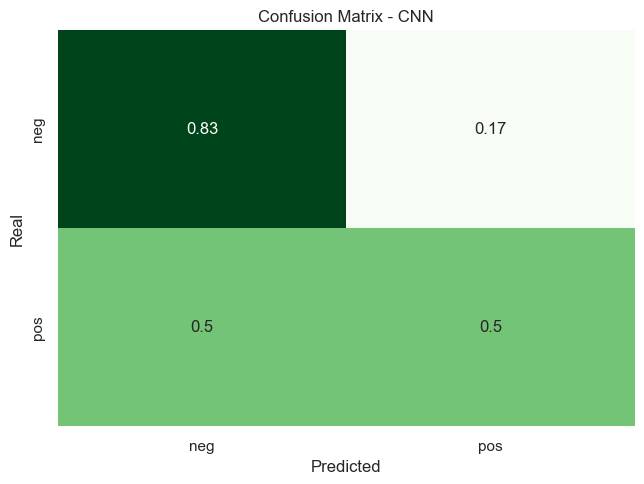

In [25]:
# x_test_dv = torch.tensor(x_test.toarray(), dtype=torch.float32)
x_test_dv = torch.tensor(x_test_chi2.toarray(), dtype=torch.float32)
x_test_dv = x_test_dv.reshape(-1, 1, n_features)
y_test_dv = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(x_test_dv, y_test_dv)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test(modelCNN, test_loader, "CNN")

In [26]:
#Exportar datos a csv
x_submit_t = torch.tensor(x_submit_chi2.toarray(), dtype=torch.float32)
x_submit_t = x_submit_t.reshape(-1, 1, n_features)
submit_dataset = TensorDataset(x_submit_t)
submit_loader = DataLoader(submit_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_preds = []
modelCNN.eval()
with torch.no_grad():
    for batch in submit_loader:
        batch = batch[0].to(device)
        pred = modelCNN(batch)
        pred = torch.argmax(pred, dim=1).cpu()
        all_preds.extend(pred)

label_map = {0: 'neg', 1: 'pos'}
labels = [label_map[label.item()] for label in all_preds]

ids = list(range(len(labels)))
submission_df = pd.DataFrame({'ids': ids, 'label': labels})

submission_df.to_csv('submit.csv', index=False)

----
# MISC



In [36]:
#clear memory
import gc
import torch

gc.collect()            # Llama al recolector de basura para liberar memoria
torch.cuda.empty_cache()  # Limpia la memoria de GPU

In [37]:
#delete all variables
for name in dir():
    if not name.startswith('_'):
        del globals()[name]
        
del name